In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.feature import PCA

In [3]:
conf = SparkConf().setMaster("local[*]")
sc = SparkContext(conf=conf)

In [4]:
spark = SparkSession\
    .builder\
    .appName("MyApp")\
    .getOrCreate()

## Load the dataset

In [5]:
df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("inferschema", "true")\
    .option("delimiter",",")\
    .load("Datasets/data_with_300_features.csv")#.repartition(3)

## Explore the dataset

In [6]:
df.printSchema()

root
 |-- f_1: double (nullable = true)
 |-- f_2: double (nullable = true)
 |-- f_3: double (nullable = true)
 |-- f_4: double (nullable = true)
 |-- f_5: double (nullable = true)
 |-- f_6: double (nullable = true)
 |-- f_7: double (nullable = true)
 |-- f_8: double (nullable = true)
 |-- f_9: double (nullable = true)
 |-- f_10: double (nullable = true)
 |-- f_11: double (nullable = true)
 |-- f_12: double (nullable = true)
 |-- f_13: double (nullable = true)
 |-- f_14: double (nullable = true)
 |-- f_15: double (nullable = true)
 |-- f_16: double (nullable = true)
 |-- f_17: double (nullable = true)
 |-- f_18: double (nullable = true)
 |-- f_19: double (nullable = true)
 |-- f_20: double (nullable = true)
 |-- f_21: double (nullable = true)
 |-- f_22: double (nullable = true)
 |-- f_23: double (nullable = true)
 |-- f_24: double (nullable = true)
 |-- f_25: double (nullable = true)
 |-- f_26: double (nullable = true)
 |-- f_27: double (nullable = true)
 |-- f_28: double (nullable = tr

In [7]:
df.select("y").distinct().sort("y").show()

+---+
|  y|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
| 10|
+---+



## Apply Vector Assembler

In [8]:
features = df.columns[0:len(df.columns)-1]

In [9]:
assembler = VectorAssembler()\
    .setInputCols(features)\
    .setOutputCol("features")

In [10]:
df_v = assembler.transform(df)\
    .select(col("features"), col("y").alias("label"))

df_v.show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.11699443,0...|    1|
|[0.0,0.11699443,0...|    1|
|[0.0,0.11699443,0...|    1|
|[0.0,0.11699443,0...|    1|
|[0.0,0.11699443,0...|    1|
|[0.0,0.11699443,0...|    1|
|[0.0,0.11699443,0...|    1|
|[0.0,0.11699443,0...|    1|
|[0.0,0.11699443,0...|    1|
|[0.0,0.11699443,0...|    1|
+--------------------+-----+
only showing top 10 rows



## Scale the features

In [11]:
scaler = StandardScaler()\
    .setInputCol("features")\
    .setOutputCol("scaledFeatures")

In [12]:
df_s = scaler.fit(df_v).transform(df_v)

## Dimensionality Reduction with PCA

In [13]:
pca = PCA()\
    .setInputCol("scaledFeatures")\
    .setOutputCol("pcaFeatures")\
    .setK(2)

In [14]:
df_p = pca.fit(df_s).transform(df_s)

In [15]:
df_p.show(10)

+--------------------+-----+--------------------+--------------------+
|            features|label|      scaledFeatures|         pcaFeatures|
+--------------------+-----+--------------------+--------------------+
|[0.0,0.11699443,0...|    1|[0.0,0.1168878569...|[-9.0844791376663...|
|[0.0,0.11699443,0...|    1|[0.0,0.1168878569...|[-9.2363439345140...|
|[0.0,0.11699443,0...|    1|[0.0,0.1168878569...|[-2.2189062710583...|
|[0.0,0.11699443,0...|    1|[0.0,0.1168878569...|[-11.111984211034...|
|[0.0,0.11699443,0...|    1|[0.0,0.1168878569...|[-8.5722489709499...|
|[0.0,0.11699443,0...|    1|[0.0,0.1168878569...|[-9.2914624899164...|
|[0.0,0.11699443,0...|    1|[0.0,0.1168878569...|[-11.146332758445...|
|[0.0,0.11699443,0...|    1|[0.0,0.1168878569...|[-11.982793957225...|
|[0.0,0.11699443,0...|    1|[0.0,0.1168878569...|[-2.3912925397431...|
|[0.0,0.11699443,0...|    1|[0.0,0.1168878569...|[-12.009468851563...|
+--------------------+-----+--------------------+--------------------+
only s

## Plot the first two principal components

In [16]:
x = df_p.select("pcaFeatures").collect()
x1 = [x[row][0][0] for row in range(0,len(x))]
x2 = [x[row][0][1] for row in range(0,len(x))]

In [17]:
y = df.select("y").collect()
y = [y[row][0] for row in range(0,len(y))]

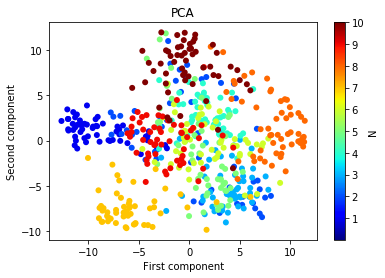

In [18]:
plt.scatter(x1, x2, cmap = "jet", c = y, marker = "o", edgecolor = "none", vmin = 0, vmax = 10)
cbar = plt.colorbar()
cbar.set_label("N")
cbar.set_ticks([1,2,3,4,5,6,7,8,9,10])
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('PCA')
plt.show()